In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess


#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess


import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np


from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point

In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records (list of dicts) to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [3]:
# Process POLARIS Raster Image Part 1 of 2

# Create function with description to process raster images
def process_image(url, soil_prop, soil_stat, soil_depth, bounds_gdf):
    """
    Load, crop, and scale raster images for multiple sites.

    Parameters
    ----------
    url: str
      URL or path for raster files.
    soil_prop: str
      Soil property (e.g., "sand", "clay", etc.)
    soil_stat: str
      Soil statistic (e.g., "mean", "median", etc.)
    soil_depth: str
      Soil depth (e.g., "30-60cm", "60-100cm", etc.)
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to.
    site_names: list
      List of site names to be used as dictionary keys.
    Returns
    -------
   merged_da: rxr.DataArray
      Processed rasters 
    """

    # Iterate through the list of bounding GeoDataFrames (areas of interest)
    #for site_name, bounds_gdf in zip(site_names, bounds_gdfs):

    # Get the study bounds
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    bounds_gdf
    .to_crs(4326)
    .total_bounds 
    )

     # List to store cropped DataArrays for the current site
    da_list = []
    
    # Loop through bounding box coordinates
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
      for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):

        # Format the URL with the current coordinates and other parameters
        formated_url = (
          url.format( 
              soil_prop = soil_prop, 
              soil_stat = soil_stat, 
              soil_depth = soil_depth,
              min_lat=min_lat , max_lat=min_lat+1,
              min_lon=min_lon, max_lon=min_lon+1 )
        )

        # Connect to the raster image
        da = rxr.open_rasterio(
        formated_url, 
        mask_and_scale=True
        ).squeeze()
        
        # Crop the raster image to the bounds of the study area
        cropped_da = (
        da.rio.clip_box(bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat)
        )

        # Append the cropped DataArray to the list
        da_list.append(cropped_da)   

    # Merge the cropped DataArrays for this site
    merged_da = merge_arrays(da_list)

    return merged_da

In [12]:
# Process POLARIS raster image part 2 of 2
# Test the function by defining variables and plotting

# Set the site parameters
# soil variables
soil_prop = 'clay'
soil_stat = 'mean'
soil_depth = '0_5'
# set up url template
soil_url_template = (
            "http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/{soil_prop}"
            "/{soil_stat}"
            "/{soil_depth}"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
clay_dir= os.path.join(habitat_suitability_data_dir, 'clay')
os.makedirs(polaris_dir, exist_ok=True)

In [11]:
# Create new variables for each study area using the process_image function

# soil variables
soil_prop = 'clay'
soil_stat = 'mean'
soil_depth = '0_5'

#Comanche National Grassland
clay_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
polaris_processed_da_list = [
clay_processed]

# Call the list to make sure it worked/looks right
polaris_processed_da_list

[<xarray.DataArray (y: 3745, x: 3472)> Size: 52MB
 array([[12.040488 , 12.040488 , 12.040488 , ..., 26.5      , 26.5      ,
         26.5      ],
        [12.434634 , 12.040488 , 12.040488 , ..., 26.5      , 26.5      ,
         26.5      ],
        [12.7928505, 12.7928505, 12.7928505, ..., 26.5      , 26.5      ,
         26.5      ],
        ...,
        [ 9.931641 ,  9.412916 ,  8.860079 , ..., 28.698826 , 28.845703 ,
         28.767122 ],
        [ 9.533171 ,  9.450147 ,  8.930664 , ..., 28.676298 , 28.15918  ,
         11.585211 ],
        [ 9.391602 ,  9.351418 ,  9.351418 , ..., 28.564642 , 28.589931 ,
         28.589931 ]], dtype=float32)
 Coordinates:
   * x            (x) float64 28kB -106.2 -106.2 -106.2 ... -105.2 -105.2 -105.2
   * y            (y) float64 30kB 40.89 40.89 40.89 40.89 ... 39.85 39.85 39.85
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     nan]

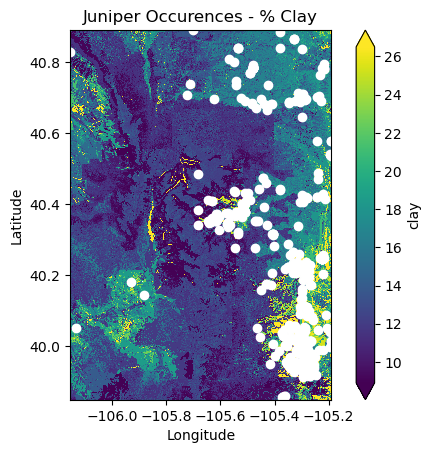

In [10]:
reproj_gdf = juniper_occur_gdf.to_crs(juniper_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
juniper_processed.plot(
    cbar_kwargs={"label": "clay"},
    robust=True,
    )

juniper_occur_gdf.to_crs(juniper_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - % Clay',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
plt.show()

In [13]:
# Process POLARIS raster image part 2 of 2
# Test the function by defining variables and plotting

# Set the site parameters
# soil variables
soil_prop = 'sand'
soil_stat = 'mean'
soil_depth = '0_5'

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
sand_dir= os.path.join(habitat_suitability_data_dir, 'sand')
os.makedirs(polaris_dir, exist_ok=True)

In [ ]:
# Create new variables for each study area using the process_image function

# soil variables
soil_prop = 'sand'
soil_stat = 'mean'
soil_depth = '0_5'

#Comanche National Grassland
clay_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
polaris_processed_da_list = [
clay_processed]

# Call the list to make sure it worked/looks right
polaris_processed_da_list

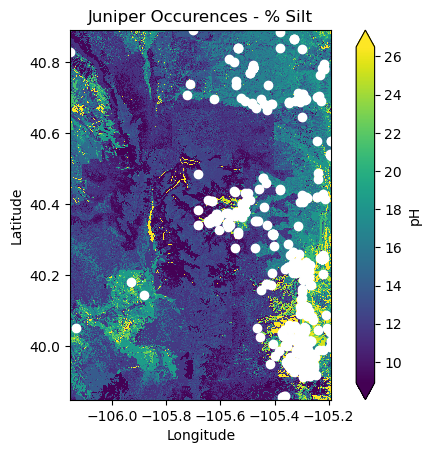

In [9]:
reproj_gdf = juniper_occur_gdf.to_crs(juniper_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
sand_processed.plot(
    cbar_kwargs={"label": "sand"},
    robust=True,
    )

juniper_occur_gdf.to_crs(juniper_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - % sand',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
plt.show()